In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [35]:
import time
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from enum import Enum, IntEnum

import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
from torch import nn
from torchsummary import summary
import torch
print (f'torch.__version__: {torch.__version__}')
import tensorflow as tf
import cv2 as cv
from torchvision import transforms
import pickle

import enums
import viz
import configuration
import customdataset
import transformers
import models
import feature_helpers
from utilmethods import create_output_folders, check_torch_mps_device, make_torch_deterministic

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, validation_curve
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from scipy.stats import loguniform

from tqdm.notebook import tqdm

check_torch_mps_device()
device = 'cpu'
device = 'mps'

config = configuration.Configuration()
face_config = configuration.FaceConfig(config)
pose_config = configuration.PoseConfig(config)
feature_extractor = feature_helpers.FeatureExtractor(config, face_config, pose_config, tqdm)

LABELS_TO_INCLUDE = config.class_dict.keys()
# LABELS_TO_INCLUDE=[0,1,2,9]

# When num samples increases plotting PCA and TSNE can crash. So better to not run those cells during the main training.    
NUM_SAMPLES_TO_LOAD = 540
IMAGE_TYPES = [enums.ImageTypes.ORIGINAL,enums.ImageTypes.POSE, enums.ImageTypes.FACE]

torch.__version__: 1.13.0
tensor([1.], device='mps:0')


## Load Data

In [4]:
%%time
# Load the data
data = feature_extractor.load_data(image_types=IMAGE_TYPES, labels=LABELS_TO_INCLUDE, shuffle=True, sample_type=enums.SampleType.TRAIN_VALIDATION,
                                   count_per_label=NUM_SAMPLES_TO_LOAD, include_feature_vectors=False)
print(f'Loaded {data.shape[0]} samples.')


Loading 5400 samples:   0%|          | 0/5400 [00:00<?, ?samples/s]

Loaded 5400 samples.
CPU times: user 7min 10s, sys: 1min 19s, total: 8min 29s
Wall time: 1min 29s


In [5]:
%%time
all_features = feature_extractor.load_feature_vectors(config.FEATURE_VECTORS_FOLDER, data[enums.DataColumn.FILENAME.value], data[enums.DataColumn.LABEL.value])
# pixel_features = data[enums.DataColumn.PIXEL_VECTOR.value].to_numpy()
# hog_features = data[enums.DataColumn.HOG_VECTOR.value].to_numpy()
# cnn_features = data[enums.DataColumn.CNN_VECTOR.value].to_numpy()
# canny_features = data[enums.DataColumn.CANNY_VECTOR.value].to_numpy()
# pose_features = data[enums.DataColumn.POSE_VECTOR.value].to_numpy()
features_names = ['Pixel', 'Hog', 'CNN', 'Canny', 'Pose', 'Keypoints', ]
[pixel_features, hog_features, cnn_features, canny_features, pose_features, keypoints_features, _, rh_angles, lh_angles] = all_features
# Just keep cnn and keypoints_features as other features are too big.
features_list = [keypoints_features]
features_names = ['Keypoints']
y = data[enums.DataColumn.LABEL.value]

print(f'Loaded {data.shape[0]} samples with {data.columns} columns.')
print(f'hog_features:{hog_features.shape}, hog_features.min:{np.min(hog_features)}, hog_features.max:{np.max(hog_features)}')
print(f'pixel_features:{pixel_features.shape}, pixel_features.min:{np.min(pixel_features)}, pixel_features.max:{np.max(pixel_features)}')
print(f'cnn_features:{cnn_features.shape}, cnn_features.min:{np.min(cnn_features)}, cnn_features.max:{np.max(cnn_features)}')
print(f'canny_features:{canny_features.shape}, canny_features.min:{np.min(canny_features)}, canny_features.max:{np.max(canny_features)}')
print(f'pose_features:{pose_features.shape}, pose_features.min:{np.min(pose_features)}, pose_features.max:{np.max(pose_features)}')
print(f'keypoints_features:{keypoints_features.shape}, keypoints_features.min:{np.min(keypoints_features)}, keypoints_features.max:{np.max(keypoints_features)}')
print(f'rh_angles:{rh_angles.shape}, rh_angles.min:{np.min(rh_angles)}, rh_angles.max:{np.max(rh_angles)}')
print(f'lh_angles:{lh_angles.shape}, lh_angles.min:{np.min(lh_angles)}, lh_angles.max:{np.max(lh_angles)}')

print()


Loading feature vectors:   0%|          | 0/5400 [00:00<?, ?images/s]

Loaded 5400 samples with Index(['filename', 'label', 'original', 'pose', 'face'], dtype='object') columns.
hog_features:(5400, 5776), hog_features.min:0.0, hog_features.max:1.0
pixel_features:(5400, 25600), pixel_features.min:0.0, pixel_features.max:0.9999000430107117
cnn_features:(5400, 2048), cnn_features.min:0.0, cnn_features.max:1.607669472694397
canny_features:(5400, 25600), canny_features.min:0, canny_features.max:255
pose_features:(5400, 65536), pose_features.min:0.0, pose_features.max:0.6640035510063171
keypoints_features:(5400, 26), keypoints_features.min:-0.5003660321235657, keypoints_features.max:0.9989637667923688
rh_angles:(5400,), rh_angles.min:0.14272619159056515, rh_angles.max:359.62695604525277
lh_angles:(5400,), lh_angles.min:5.817067027043849, lh_angles.max:357.32084582961005

CPU times: user 8.28 s, sys: 4.87 s, total: 13.2 s
Wall time: 20.6 s


## Dimensionality Reduction

In [24]:
# Helpers for vizualizing
def plot_PCA(X_list, names, n_components=2):
    pca_list, xpca_list = feature_extractor.get_PCA(X_list, n_components=n_components)
    plt.figure(figsize=(15,5))
    colors = ['b-', 'g-', 'r-', 'k-', 'y-']
    plot_labels = [f'{name} features' for name in names]
    for i in range(len(X_list)):
        plt.plot(np.cumsum(pca_list[i].explained_variance_ratio_), colors[i], label=plot_labels[i])
    plt.xticks(np.arange(n_components)+1)
    plt.yticks(np.linspace(0, 1, 8))
    plt.grid(visible=True)
    plt.xlabel('Number of components')
    plt.ylabel('Explained Variances')
    plt.legend()
    plt.tight_layout(pad=0.1, h_pad=None, w_pad=None, rect=None)
    plt.show()

def plot_classes(X, y, ax, title, included_labels):
    colormap = plt.cm.gist_rainbow # hsv tab20 #nipy_spectral #, Set1,Paired
    colorst = [colormap(i) for i in np.linspace(0, 1.0, len(np.unique(y)))]
    markers = ['o', 'v', 's', 'p', 'x', '>', '*', '<', 'P', '^']
    for k, label in enumerate(included_labels):
        marker = markers[k % len(markers)]
        if X.shape[1] == 2:
            ax.scatter(X[y==label, 0], X[y==label, 1], facecolors=colorst[k], marker=marker, label=config.class_dict[label])
        else:
            ax.scatter(X[y==label, 0], X[y==label, 1], X[y==label, 2], facecolors=colorst[k], marker=marker, label=config.class_dict[label])
    ax.set_title(title)
    
def plot_components(features_list, X_pcas, X_tsnes, names, included_labels=LABELS_TO_INCLUDE):
    # project the features into 2 dimensions
    fig, ax = plt.subplots(nrows=len(features_list), ncols=2, figsize=(10,5))
    if len(features_list) == 1:
        ax = [ax]

    # y is the class labels
    for i in range(len(features_list)):
        plot_classes(X_pcas[i], y, ax[i][0], title=f'{names[i]} PCA', included_labels=LABELS_TO_INCLUDE)
        plot_classes(X_tsnes[i], y, ax[i][1], title=f'{names[i]} tSNE', included_labels=LABELS_TO_INCLUDE)
    
    handles, plot_labels = ax[0][0].get_legend_handles_labels()
    fig.legend(handles, plot_labels, loc='upper center')
    plt.tight_layout(pad=0.1, h_pad=None, w_pad=12, rect=None)
    plt.show()

In [25]:
print(f'features_list: {len(features_list)}')
print(np.array(features_list[0]).shape)

features_list: 1
(5400, 26)


Doing PCA(23):   0%|          | 0/1 [00:00<?, ?images/s]

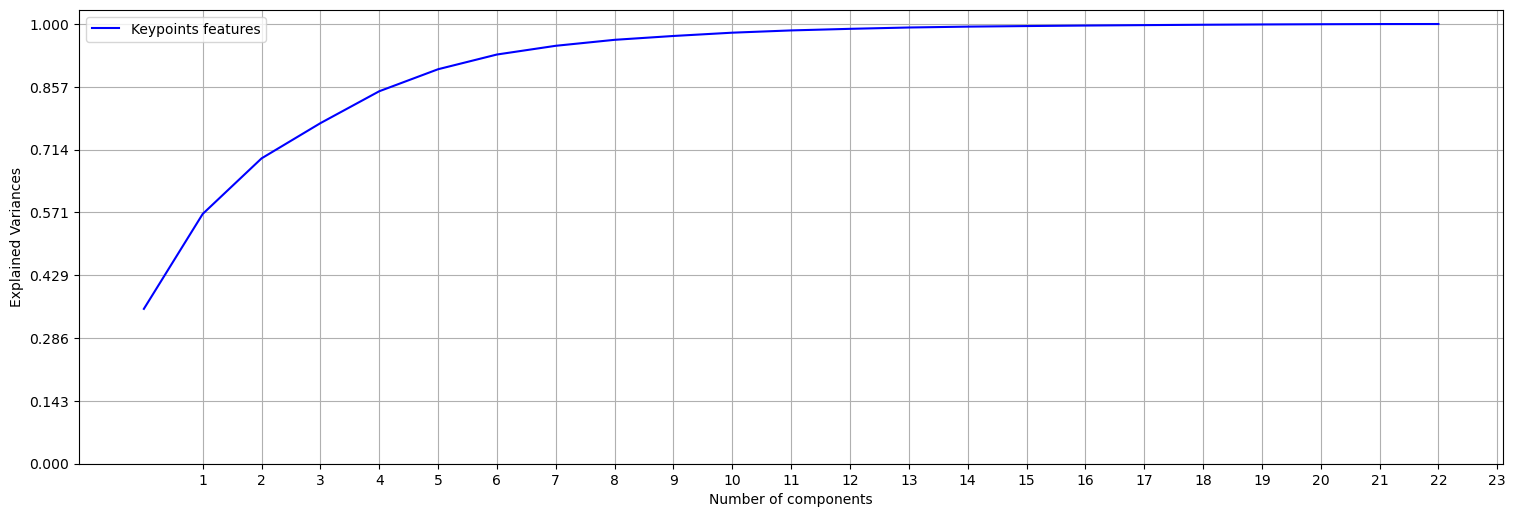

CPU times: user 1.35 s, sys: 74.9 ms, total: 1.42 s
Wall time: 360 ms


In [26]:
%%time
plot_PCA(features_list, features_names, n_components=23)

Doing PCA(2):   0%|          | 0/1 [00:00<?, ?images/s]

Doing tSNE(2):   0%|          | 0/1 [00:00<?, ?images/s]

/Users/rasentha/opt/anaconda3/envs/amd-gpu2/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


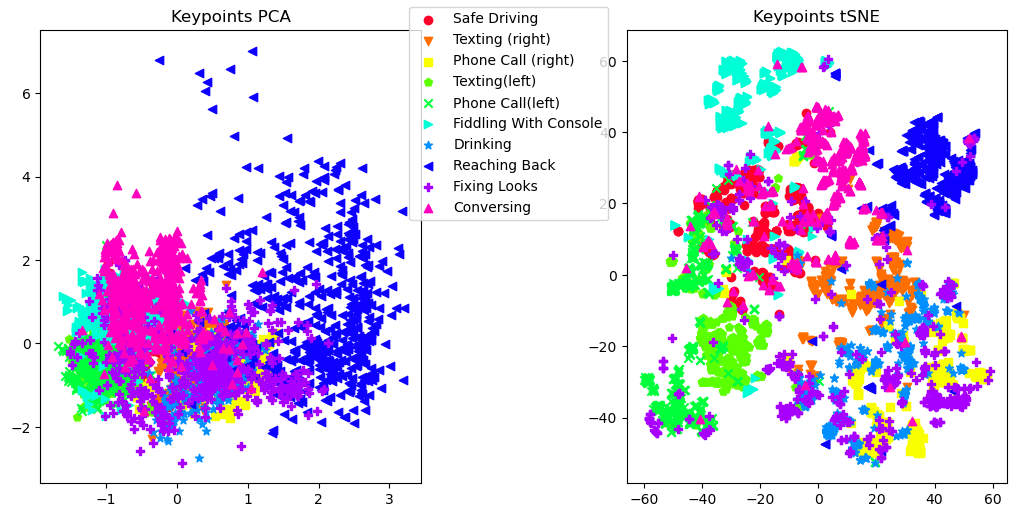

CPU times: user 1min 53s, sys: 2.54 s, total: 1min 55s
Wall time: 21.3 s


In [27]:
%%time
def visualize_components():
    pcas = feature_extractor.get_PCA(features_list, n_components=2)[-1]
    tsnes = feature_extractor.get_tsne(features_list, n_components=2)
    plot_components(features_list, 
                    pcas, 
                    tsnes,
                    features_names,
                    included_labels=LABELS_TO_INCLUDE)
visualize_components()

## KNN Classification

In [28]:
# Load feature vectors
# X_pixels_pca, X_hog_pca, X_CNN_pca, X_canny_pca, X_pose_pca = feature_extractor.get_PCA(features_list, n_components=2)[-1]
# X_pixels_tsne, X_hog_tsne, X_CNN_tsne, X_canny_tsne, X_pose_tsne = feature_extractor.get_tsne(features_list, n_components=2)
[X_keypoints_pca] = feature_extractor.get_PCA(features_list, n_components=2)[-1]
print(np.array(X_keypoints_pca).shape)
[X_keypoints_tsne] = feature_extractor.get_tsne(features_list, n_components=2)
print(np.array(X_keypoints_tsne).shape)

Doing PCA(2):   0%|          | 0/1 [00:00<?, ?images/s]

(5400, 2)


Doing tSNE(2):   0%|          | 0/1 [00:00<?, ?images/s]

/Users/rasentha/opt/anaconda3/envs/amd-gpu2/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


(5400, 2)


In [29]:
def calc_accuracy(knn, pca, y, idx):
    knn.fit(pca, y)
    accuracy = 0
    for i in idx:
        label = knn.predict([pca[i,:]])
        if label[0] == y[i]:
            accuracy +=1
    return accuracy

def accuracies(n_samples):
    knn = KNeighborsClassifier(n_neighbors = 3)
    idx = np.random.choice(np.arange(len(y)), n_samples, replace=False)
    # print(y[idx])
    print(f'Accuracies from {n_samples} samples:')
    # print('Pixel PCA Accuracy: ', calc_accuracy(knn, X_pixels_pca, y, idx)/n_samples)
    # print('Pixel tSNE Accuracy: ', calc_accuracy(knn, X_pixels_tsne, y, idx)/n_samples)
    # print('HOG PCA Accuracy: ', calc_accuracy(knn, X_hog_pca, y, idx)/n_samples)
    # print('HOG tSNE Accuracy: ', calc_accuracy(knn, X_hog_tsne, y, idx)/n_samples)
    # print('CNN PCA Accuracy: ', calc_accuracy(knn, X_CNN_pca, y, idx)/n_samples)
    # print('CNN tSNE Accuracy: ', calc_accuracy(knn, X_CNN_tsne, y, idx)/n_samples)
    # print('Canny PCA Accuracy: ', calc_accuracy(knn, X_canny_pca, y, idx)/n_samples)
    # print('Canny tSNE Accuracy: ', calc_accuracy(knn, X_canny_tsne, y, idx)/n_samples)
    # print('Pose PCA Accuracy: ', calc_accuracy(knn, X_pose_pca, y, idx)/n_samples)
    # print('Pose tSNE Accuracy: ', calc_accuracy(knn, X_pose_tsne, y, idx)/n_samples)
    # print('Keypoints PCA Accuracy: ', calc_accuracy(knn, X_keypoints_pca, y, idx)/n_samples)
    print('Keypoints tSNE Accuracy: ', calc_accuracy(knn, X_keypoints_tsne, y, idx)/n_samples)

accuracies(100)

Accuracies from 100 samples:
Keypoints tSNE Accuracy:  0.94


## PCA and Logistic Regression

In [6]:
# get the train and test split
# [pixel_features, hog_features, cnn_features, canny_features, pose_features] = feature_extractor.load_feature_vectors(config.FEATURE_VECTORS_FOLDER, data['filename'], data['label'])
train_idx, val_idx = train_test_split(np.arange(len(y)), test_size=0.2, random_state=config.SEED)

In [7]:
def train_classifier(in_feat, in_y, in_train_idx, val_idx):
    # get the train and validation split
    X_train = in_feat[in_train_idx, :].copy()
    y_train = in_y[in_train_idx].copy()
    X_val = in_feat[val_idx, :].copy()
    y_val = in_y[val_idx].copy()

    # scaling
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)

    # classifier with cross validation
    
    # 1e-5, 1e-4, 1e-3, ..., 1, 10, 100,
    param_grid = {"C": loguniform(1e-3, 1e5)}
    # clf = RandomizedSearchCV(LogisticRegression(solver='liblinear', random_state=config.SEED), param_grid, n_iter=100)
    clf = RandomizedSearchCV(LogisticRegression(penalty='l1', max_iter=5000, solver='saga', random_state=config.SEED), param_grid, n_iter=10)
    clf = clf.fit(X_train, y_train)
    y_pred = clf.predict(X_val)

    return metrics.accuracy_score(y_val, y_pred)

In [32]:
def train_and_check(features, n_components, name, y, train_idx, val_idx):
    pbar = tqdm(desc=name, total=len(n_components) + 1, position=0, leave=True)
    acc = []
    for n in n_components:
        pbar.set_description(f'{name}: Computing PCA({n})')
        _, X = feature_extractor.get_PCA([features], n_components=n+1)
        acc.append(train_classifier(X[0], y, train_idx, val_idx))
        pbar.update(1)
    pbar.set_description(f'{name}: Training classifier')
    acc.append(train_classifier(features, y, train_idx, val_idx))
    pbar.update(1)
    pbar.close()
    return acc

# get accuracy with different features
n_components = [50, 100, 150, 200]
n_components = [200]
n_components = [3, 6, 9, 12, 15, 18, 21, 23]
# print('Pixel Feature Accuracy')
# pixel_acc = train_and_check(pixel_features, n_components, 'Pixel', y, train_idx, val_idx)
# print('Pose Feature Accuracy')
# pose_acc = train_and_check(pose_features, n_components, 'Pose', y, train_idx, val_idx)
print('Keypoints Feature Accuracy')
keypoints_acc = train_and_check(keypoints_features, n_components, 'Keypoints', y, train_idx, val_idx)
# print('CNN Feature Accuracy')
# CNN_acc = train_and_check(CNN_features, n_components, 'CNN', y, train_idx, val_idx)

# pixel_tqdm = tqdm(prefix='Pixel', total=len(n_components) + 1, position=0, leave=True)
# pixel_acc = []
# for n in n_components:
#     pixel_tqdm.set_description(f'Computing PCA({n})')
#     _, X = feature_extractor.get_PCA([pixel_features], n_components=n+1)
#     pixel_acc.append(train_classifier(X[0], y, train_idx, val_idx))
#     pixel_tqdm.update(1)
# pixel_tqdm.set_description(f'Training calssifier')
# pixel_acc.append(train_classifier(pixel_features, y, train_idx, val_idx))
# pixel_tqdm.update(1)
# pixel_tqdm.close()

# print('Pose Feature Accuracy')
# pose_acc = []
# for n in range(n_components):
#   _, X = feature_extractor.get_PCA([pose_features], n_components=n+1)
#   pose_acc.append(train_classifier(X[0], y, train_idx, val_idx))
# pose_acc.append(train_classifier(pose_features, y, train_idx, val_idx))

# print('CNN Feature Accuracy')
# CNN_acc = []
# for n in range(n_components):
#   _, X = feature_extractor.get_PCA([CNN_features], n_components=n+1)
#   CNN_acc.append(train_classifier(X[0], y, train_idx, val_idx))
# CNN_acc.append(train_classifier(CNN_features, y, train_idx, val_idx))

Keypoints Feature Accuracy


Keypoints:   0%|          | 0/9 [00:00<?, ?it/s]

Doing PCA(4):   0%|          | 0/1 [00:00<?, ?images/s]

Doing PCA(7):   0%|          | 0/1 [00:00<?, ?images/s]

Doing PCA(10):   0%|          | 0/1 [00:00<?, ?images/s]

Doing PCA(13):   0%|          | 0/1 [00:00<?, ?images/s]

Doing PCA(16):   0%|          | 0/1 [00:00<?, ?images/s]

Doing PCA(19):   0%|          | 0/1 [00:00<?, ?images/s]

Doing PCA(22):   0%|          | 0/1 [00:00<?, ?images/s]

Doing PCA(24):   0%|          | 0/1 [00:00<?, ?images/s]

/Users/rasentha/opt/anaconda3/envs/amd-gpu2/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/rasentha/opt/anaconda3/envs/amd-gpu2/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/rasentha/opt/anaconda3/envs/amd-gpu2/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [34]:
print(keypoints_acc)

[0.6703703703703704, 0.7194444444444444, 0.7481481481481481, 0.7648148148148148, 0.7731481481481481, 0.8157407407407408, 0.812037037037037, 0.8203703703703704, 0.8287037037037037]


/var/folders/s4/p0y554f56hd_d9fk8y79dy3c0000gs/T/ipykernel_27855/565228329.py:12: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True)


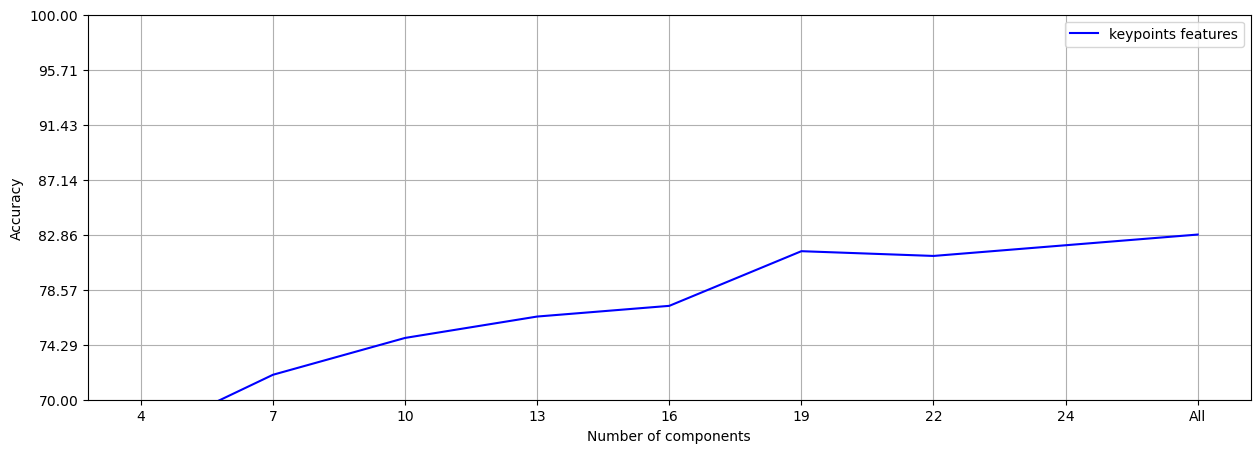

In [35]:
# plot the accuracy graph
plt.figure(figsize=(15,5))
# plt.plot(np.array(pixel_acc)*100, 'b-', label='pixel features')
# plt.plot(np.array(pose_acc)*100, 'g-', label='pose features')
# plt.plot(np.array(CNN_acc)*100, 'k-', label='CNN features')

plt.plot(np.array(keypoints_acc)*100, 'b-', label='keypoints features')

xtick_labels = [f'{i+1}' for i in n_components] + ['All']
plt.xticks(np.arange(len(n_components) + 1), labels=xtick_labels)
plt.yticks(np.linspace(70, 100, 8))
plt.grid(b=True)
plt.xlabel('Number of components')
plt.ylabel('Accuracy')
plt.ylim([70, 100])
plt.legend()
plt.show()

## Logistic Regression

In [10]:
%%time
def logit_classifier(in_feat, in_y, in_train_idx, val_idx, grid_params, max_iter=5000):
    # get the train and validation split
    X_train = in_feat[in_train_idx, :].copy()
    y_train = in_y[in_train_idx].copy()
    X_val = in_feat[val_idx, :].copy()
    y_val = in_y[val_idx].copy()

    # scaling
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    # Save scaler for future use.
    pickle.dump(scaler, open(f'{config.OUTPUT_FOLDER}/logit_model_saved/validation_scaler.pkl','wb'))

    # classifier with cross validation
    # clf = RandomizedSearchCV(LogisticRegression(solver='liblinear', random_state=config.SEED), param_grid, n_iter=100)
    clf = RandomizedSearchCV(LogisticRegression(penalty='elasticnet', solver='saga', random_state=config.SEED, max_iter=max_iter),
                       grid_params, return_train_score=True, scoring='neg_log_loss')
    clf = clf.fit(X_train, y_train)
    y_pred = clf.predict(X_val)
    return clf, metrics.accuracy_score(y_val, y_pred)

# Parameter space for random search hyper parameter tuning.
# grid_params = {
#     'C': loguniform(1e-3, 1e5),
#     'l1_ratio': [.3, .4, .5, 0.55, 0.6, 0.65, .7, .8, .9, 1.0],}

# Parameter space for random search hyper parameter tuning.
grid_params = {
    'C': loguniform(50, 2*1e2),
    'l1_ratio': loguniform(0.3, 0.9)}

# Random search of hyper parameters
logit_clf, accuracy = logit_classifier(keypoints_features, y, train_idx, val_idx, grid_params=grid_params)

CPU times: user 22min 44s, sys: 4.88 s, total: 22min 48s
Wall time: 22min 9s


In [15]:
print(f'Best params:{logit_clf.best_params_}')
print(f'Validation accuracy: {accuracy}')
# save model
def save():
    filename = f'{config.OUTPUT_FOLDER}/logit_model_saved/multiclass_random_hyperparam_model.pkl'
    with open(filename, 'wb') as file:
        pickle.dump(logit_clf, file)
save()
# print(f'validation accuracy: {accuracy}')
# print(pd.DataFrame(logit_clf.cv_results_).columns, pd.DataFrame(logit_clf.cv_results_).shape)

# Best params:{'C': 113.59102474833026, 'l1_ratio': 0.5}
best_model = logit_clf

Best params:{'C': 50.763993085989235, 'l1_ratio': 0.44385437365185526}
Validation accuracy: 0.837037037037037


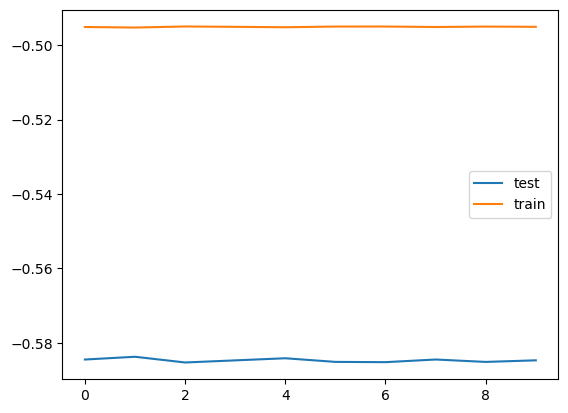

   mean_fit_time  std_fit_time  mean_score_time  std_score_time     param_C  \
0      24.849777      2.739290         0.003974        0.004548   92.456927   
1      23.904340      2.212169         0.001621        0.000227   50.763993   
2      27.582604      2.882424         0.001750        0.000283  170.621884   
3      26.220836      2.425900         0.001529        0.000073  100.736895   
4      24.571631      2.013529         0.001477        0.000066   69.955094   
5      26.013339      2.165176         0.001606        0.000190   109.02595   
6      28.402269      2.461384         0.002261        0.000989  171.378988   
7      27.235358      1.950719         0.002045        0.000379   90.390383   
8      26.638629      3.422291         0.001595        0.000176  166.539264   
9      24.515505      2.032001         0.001499        0.000054   76.377272   

  param_l1_ratio                                             params  \
0       0.311256  {'C': 92.45692742958937, 'l1_ratio': 0.31

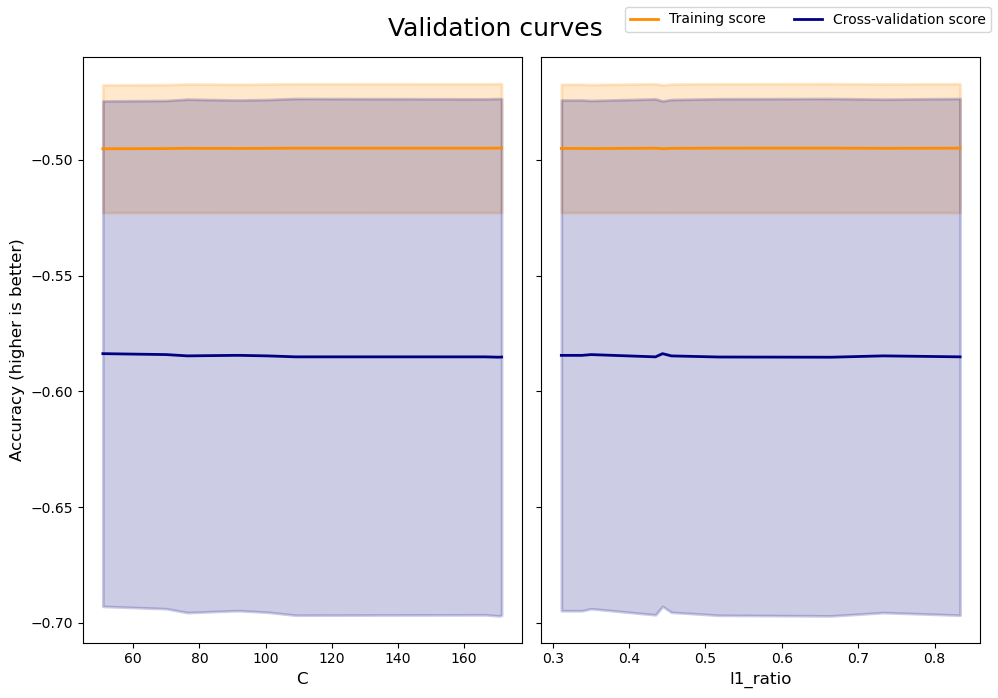

In [18]:
import math
def load_saved_model():
    filename = f'{config.OUTPUT_FOLDER}/logit_model_saved/multiclass_random_hyperparam_model.pkl'
    with open(filename, 'rb') as file:
        return pickle.load(file)

def plot_logit_classifier(clf, features, y, train_idx, val_idx, grid_params):
    test_scores = clf.cv_results_['mean_test_score']
    train_scores = clf.cv_results_['mean_train_score'] 
    plt.plot(test_scores, label='test')
    plt.plot(train_scores, label='train')
    plt.legend(loc='best')
    plt.show()

    df = pd.DataFrame(clf.cv_results_)
    print(df)
    results = ['mean_test_score',
           'mean_train_score',
           'std_test_score', 
           'std_train_score']

    # https://en.wikipedia.org/wiki/Pooled_variance#Pooled_standard_deviation
    def pooled_var(stds):
        n = 5 # size of each group
        return np.sqrt(sum((n-1)*(stds**2))/ len(stds)*(n-1))


    fig, axes = plt.subplots(1, len(grid_params),
                             figsize = (5*len(grid_params), 7),
                             sharey='row')
    axes[0].set_ylabel("Accuracy (higher is better)", fontsize=12)
    lw = 2
    for idx, (param_name, param_range) in enumerate(grid_params.items()):
        # if param_name == 'max_iter':
        #     continue
        df_filtered = df #[(df[f'param_{param_name}'] < 1000) ]
        param_range = sorted(df_filtered[f'param_{param_name}'].unique())
        grouped_df = df_filtered.sort_values(by=f'param_{param_name}').groupby(f'param_{param_name}')[results]\
            .agg({'mean_train_score': 'mean',
                  'mean_test_score': 'mean',
                  'std_train_score': pooled_var,
                  'std_test_score': pooled_var})
        
        previous_group = df_filtered.groupby(f'param_{param_name}')[results]
        axes[idx].set_xlabel(param_name, fontsize=12)
        # axes[idx].set_ylim(0.0, 1.1)
        axes[idx].plot(param_range, grouped_df['mean_train_score'], label="Training score",
                    color="darkorange", lw=lw)
        axes[idx].fill_between(param_range, grouped_df['mean_train_score'] - grouped_df['std_train_score'],
                        grouped_df['mean_train_score'] + grouped_df['std_train_score'], alpha=0.2,
                        color="darkorange", lw=lw)
        axes[idx].plot(param_range, grouped_df['mean_test_score'], label="Cross-validation score",
                    color="navy", lw=lw)
        axes[idx].fill_between(param_range, grouped_df['mean_test_score'] - grouped_df['std_test_score'],
                        grouped_df['mean_test_score'] + grouped_df['std_test_score'], alpha=0.2,
                        color="navy", lw=lw)

    handles, labels = axes[0].get_legend_handles_labels()
    fig.suptitle('Validation curves', fontsize=18)
    fig.legend(handles, labels, ncol=2, fontsize=10)
    fig.subplots_adjust(bottom=0.25, top=0.85)  
    plt.tight_layout()
    plt.savefig(f'{config.OUTPUT_FOLDER}/report_plots/logistic_regression_random_hyper_param_tuning.jpg', dpi=300)
    plt.show()

plot_logit_classifier(load_saved_model(), keypoints_features, y, train_idx, val_idx, grid_params=grid_params)


## Model Performance Against Validation Dataset

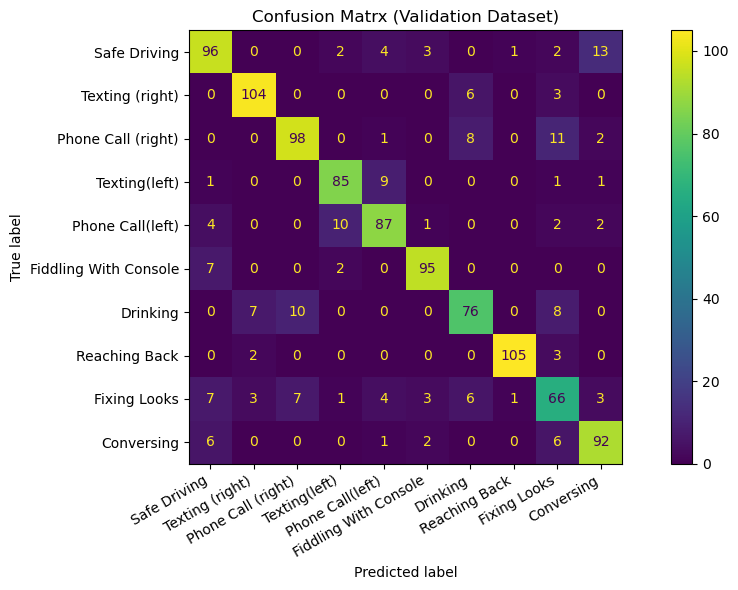

In [70]:
def test_validation_ds(X, y, dataset_name, out_file='logistic_confusion_matrix_validation.jpg'):
    mode_filename = f'{config.OUTPUT_FOLDER}/logit_model_saved/multiclass_random_hyperparam_model.pkl'
    scaler_file_name = f'{config.OUTPUT_FOLDER}/logit_model_saved/validation_scaler.pkl'

    with open(mode_filename, 'rb') as modelfile, open(scaler_file_name, 'rb') as scalerfile:
        model = pickle.load(modelfile)
        scaler = pickle.load(scalerfile)
        X_val = scaler.transform(X)
        y_pred = model.predict(X_val)
        fig, ax = plt.subplots(figsize=(10, 6))
        ax.set_title(f'Confusion Matrx ({dataset_name} Dataset)')
        disp_labels = [config.class_dict[key] for key in sorted(config.class_dict.keys())]
        cm = metrics.confusion_matrix(y, y_pred, labels=model.classes_)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=disp_labels)
        disp.plot(xticks_rotation='30', ax=ax)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')        
        plt.subplots_adjust(bottom=0.3)
        plt.savefig(f'{config.OUTPUT_FOLDER}/report_plots/{out_file}', dpi=300)
        plt.tight_layout()        
        plt.show()

    # Visualize images that the model got very wrong.
    
test_validation_ds(keypoints_features[val_idx, :].copy(), y[val_idx].copy(), dataset_name='Validation')


## Test Dataset